In [ ]:
!nvidia-smi

Fri Sep  5 14:54:46 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   61C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# Rapid colab install files and test check for GPU

In [ ]:
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!python rapidsai-csp-utils/colab/pip-install.py

Cloning into 'rapidsai-csp-utils'...
remote: Enumerating objects: 603, done.
remote: Counting objects: 100% (169/169), done.
remote: Compressing objects: 100% (87/87), done.
remote: Total 603 (delta 131), reused 82 (delta 82), pack-reused 434 (from 3)
Receiving objects: 100% (603/603), 199.38 KiB | 9.06 MiB/s, done.
Resolving deltas: 100% (305/305), done.
Installing RAPIDS remaining 25.08 libraries
Using Python 3.12.11 environment at: /usr
Resolved 180 packages in 1.07s
Prepared 40 packages in 44.07s
Uninstalled 30 packages in 978ms
Installed 40 packages in 1.38s
 - bokeh==3.7.3
 + bokeh==3.6.3
 + cucim-cu12==25.8.0
 + cuda-bindings==12.9.2
 + cuda-pathfinder==1.2.1
 - cuda-python==12.6.2.post1
 + cuda-python==12.9.2
 - cudf-cu12==25.6.0 (from https://pypi.nvidia.com/cudf-cu12/cudf_cu12-25.6.0-cp312-cp312-manylinux_2_24_x86_64.manylinux_2_28_x86_64.whl)
 + cudf-cu12==25.8.0
 + cugraph-cu12==25.8.0
 - cuml-cu12==25.6.0
 + cuml-cu12==25.8.0
 - cuvs-cu12==25.6.1
 + cuvs-cu12==25.8.0
 + cu

In [ ]:
import cudf
cudf.__version__

'25.08.00'

In [ ]:
import cuml
cuml.__version__

'25.08.00'

In [ ]:
import cugraph
cugraph.__version__

'25.08.00'

In [ ]:
import cuspatial
cuspatial.__version__

ModuleNotFoundError: No module named 'cuspatial'

# Apply Machine Learning

In [ ]:
import cudf
import cupy
import matplotlib.pyplot as plt
from cuml.cluster import KMeans as cuKMeans
from cuml.datasets import make_blobs
from sklearn.cluster import KMeans as skKMeans
from sklearn.metrics import adjusted_rand_score

%matplotlib inline

In [ ]:
# Define parameters

n_samples = 100000
n_features = 25

n_clusters = 8
random_state = 0

# Generate Datasets

In [ ]:
device_data, device_labels = make_blobs(
    n_samples=n_samples,
    n_features=n_features,
    centers=n_clusters,
    random_state=random_state,
    cluster_std = 0.1
)

In [ ]:
# copy cuPy arrays from GPU memory to host memory (Numpy arrays).
# This is done to later compare the CPU and GPU results.

host_data=device_data.get()
host_labels = device_labels.get()

# Scikit-Learn Model

In [ ]:
kmeans_sk = skKMeans(init = "k-means++", n_clusters=n_clusters, random_state=random_state, n_init='auto')
%timeit kmeans_sk.fit(host_data)

131 ms ± 37.9 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


# cuML Model

In [ ]:
kmeans_cuml = cuKMeans(init = "k-means++", n_clusters=n_clusters, random_state=random_state)
%timeit kmeans_cuml.fit(device_data)

15.6 ms ± 805 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


# Visualize Centroids

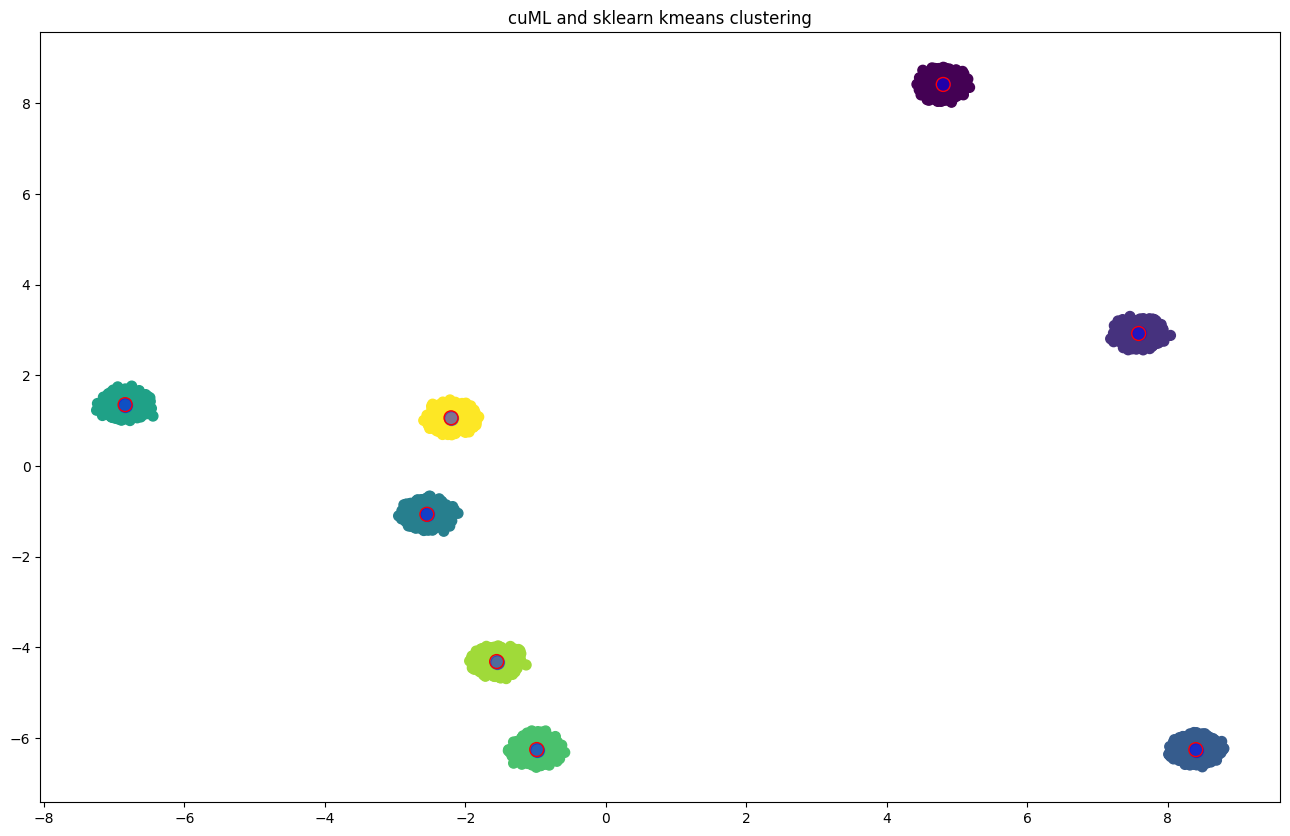

In [ ]:
fig = plt.figure(figsize=(16, 10))
plt.scatter(host_data[:,0], host_data[:,1], c=host_labels, s=50, cmap='viridis')

# plot the sklearn kmeans centers with blue filled circles
centers_sk = kmeans_sk.cluster_centers_
plt.scatter(centers_sk[:,0], centers_sk[:,1], c='blue', s=100, alpha=0.5)

# plot the cuml kmeans centers with red filled circles
centers_cuml = kmeans_cuml.cluster_centers_
plt.scatter(cupy.asnumpy(centers_cuml[:,0]), cupy.asnumpy(centers_cuml[:,1]), facecolors='none', edgecolors='red', s=100)
plt.title('cuML and sklearn kmeans clustering')
plt.show()

# compare Results

In [ ]:
cuml_score = adjusted_rand_score(host_labels, kmeans_cuml.labels_.get())
sk_score = adjusted_rand_score(host_labels, kmeans_sk.labels_)

print('cuML Adjusted Rand Score: ', cuml_score)
print('sklearn Adjusted Rand Score: ', sk_score)

cuML Adjusted Rand Score:  1.0
sklearn Adjusted Rand Score:  1.0
